In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import dill

import keras as k
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

import cv2
from tqdm import tqdm


Using Theano backend.


In [3]:
with open('tiffs.pkl', 'rb') as in_strm:
    all_info = dill.load(in_strm)
x_train = all_info[0]
x_test = all_info[1]
y_train = all_info[2]
y_test = all_info[3]

In [5]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                input_shape=(32, 32, 3)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(17, activation='sigmoid'))

model.compile(loss='binary_crossentropy', # We NEED binary here, since categorical_crossentropy l1 norms the output before calculating loss.
                    optimizer='adam',
                    metrics=['accuracy'])


model.fit(x_train, y_train, batch_size=128, epochs=2, verbose=1, 
          validation_data=(x_test, y_test))

from sklearn.metrics import fbeta_score

p_valid = model.predict(x_test, batch_size=128)
print(y_test)
print(p_valid)
print(fbeta_score(y_test, np.array(p_valid) > 0.2, beta=2, average='samples'))

Train on 35000 samples, validate on 5479 samples
Epoch 1/2
35000/35000 [==============================] - 221s - loss: 0.2706 - acc: 0.8993 - val_loss: 0.2321 - val_acc: 0.9081
Epoch 2/2
35000/35000 [==============================] - 216s - loss: 0.2378 - acc: 0.9073 - val_loss: 0.2253 - val_acc: 0.9088
[[0 1 0 ..., 0 0 0]
 [0 0 1 ..., 0 0 1]
 [0 1 0 ..., 1 0 1]
 ..., 
 [0 0 0 ..., 0 0 1]
 [0 0 1 ..., 0 0 1]
 [0 1 0 ..., 0 0 1]]
[[ 0.00759964  0.08917295  0.07961106 ...,  0.11307639  0.00113929
   0.13406722]
 [ 0.00947722  0.11039484  0.13875552 ...,  0.14864653  0.00245558
   0.23167858]
 [ 0.00919386  0.10614873  0.14739102 ...,  0.15757716  0.00208148
   0.24043851]
 ..., 
 [ 0.01242397  0.11952067  0.35257393 ...,  0.27137938  0.00570082
   0.44795612]
 [ 0.01251777  0.1212773   0.35308805 ...,  0.26714668  0.00572994
   0.45122948]
 [ 0.01015329  0.12778422  0.22944857 ...,  0.19067876  0.00331263
   0.35047132]]
0.755328488298


In [4]:
from sklearn.neural_network import BernoulliRBM

In [5]:
copy_x_train = np.copy(x_train)
copy_x_test = np.copy(x_test)
copy_y_train = np.copy(y_train)
copy_y_test = np.copy(y_test)

In [6]:
def zero_mean(matrix):
    m = matrix.mean(axis=1)
    return matrix - m[:, np.newaxis]

In [7]:
def flatten(matrix):
    vector = np.reshape(matrix, (matrix.shape[0], matrix.shape[1] * matrix.shape[2], matrix.shape[3]))
    return vector

In [8]:
copy_x_train = flatten(copy_x_train)
print(copy_x_train.shape)
copy_x_test = flatten(copy_x_test)
print(copy_x_test.shape)

(35000, 1024, 3)
(5479, 1024, 3)


In [9]:
print(copy_x_train[0])

[[ 0.04315186  0.06665039  0.07843018]
 [ 0.04315186  0.06665039  0.08233643]
 [ 0.04315186  0.06665039  0.07843018]
 ..., 
 [ 0.04315186  0.06665039  0.07843018]
 [ 0.03921509  0.06665039  0.07843018]
 [ 0.04315186  0.06665039  0.07843018]]


In [10]:
rbm = BernoulliRBM(n_components=256, random_state=0, 
                   verbose=True, learning_rate=0.000001, n_iter=10)

In [11]:
copy_x_train_red = copy_x_train[:,:,0]
copy_x_train_green = copy_x_train[:,:,1]
copy_x_train_blue = copy_x_train[:,:,2]
copy_x_test_red = copy_x_test[:,:,0]
copy_x_test_green = copy_x_test[:,:,1]
copy_x_test_blue = copy_x_test[:,:,2]

In [12]:
rbm.fit(copy_x_train_red, copy_y_train)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -671.62, time = 32.42s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -640.81, time = 25.04s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -616.68, time = 30.47s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -597.14, time = 24.59s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -580.90, time = 25.29s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -567.15, time = 28.55s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -555.31, time = 25.74s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -545.00, time = 26.47s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -535.91, time = 22.73s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -527.81, time = 22.98s


BernoulliRBM(batch_size=10, learning_rate=1e-06, n_components=256, n_iter=10,
       random_state=0, verbose=True)

In [30]:
red_prediction = rbm.transform(copy_x_train_red)

(256, 1024)


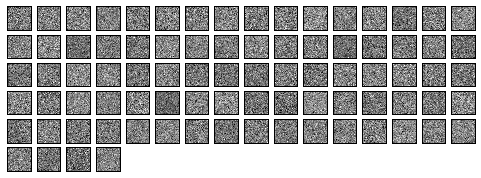

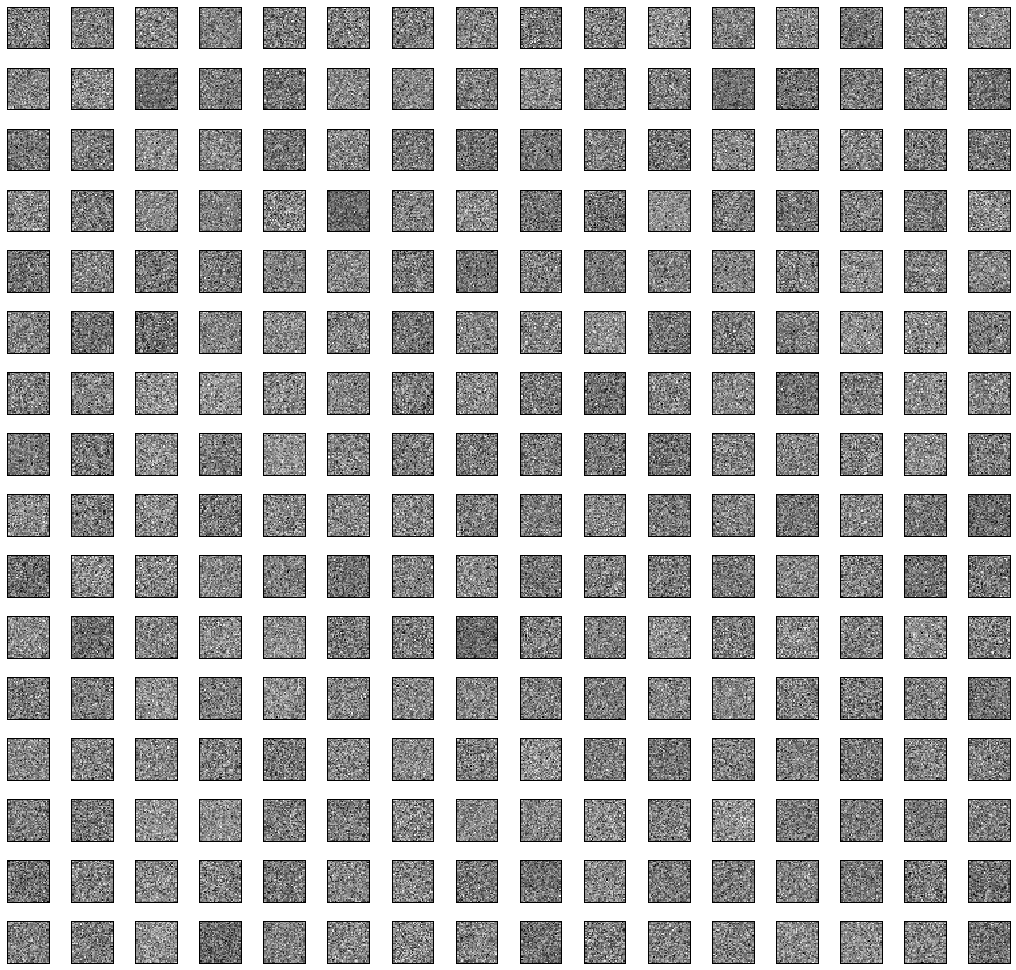

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8.4, 8))
print(rbm.components_.shape)
for i, comp in enumerate(rbm.components_):
    plt.subplot(16, 16, i + 1)
    plt.imshow(comp.reshape((32, 32)), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.subplots_adjust(0.16, 0.04, 1.84, 1.7, 0.16, 0.46)

plt.show()

(35000, 16, 16)
[[ 0.99840572  0.99958714  0.99753827  0.99916036  0.99962188  0.99943686
   0.99934752  0.99894942  0.99772527  0.99956082  0.99966618  0.9978658
   0.9992567   0.99976841  0.99953221  0.99978497]
 [ 0.99934813  0.99941484  0.99954655  0.99966573  0.99961445  0.99955733
   0.99969807  0.99877682  0.99895574  0.99922114  0.99970622  0.99841866
   0.9987188   0.99907679  0.99964952  0.99940757]
 [ 0.99943434  0.99843877  0.99929213  0.99937662  0.99946755  0.99969806
   0.9995474   0.99952722  0.9993892   0.99944635  0.99959986  0.99980188
   0.99952228  0.999117    0.99865541  0.99846747]
 [ 0.99818978  0.99967202  0.99972943  0.99952898  0.99956383  0.99837672
   0.99964878  0.99948673  0.99966024  0.99867469  0.9993097   0.9995797
   0.99589247  0.99907736  0.99933099  0.99956524]
 [ 0.9989374   0.99938966  0.99968785  0.99945462  0.99947456  0.99877446
   0.99929931  0.99962685  0.99912302  0.99977191  0.99946633  0.99952427
   0.99949588  0.99968579  0.99954759  0.9

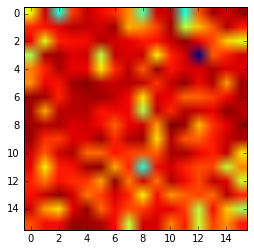

[[False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False Fal

In [41]:
print(red_prediction.shape)
red_prediction = np.reshape(red_prediction, (red_prediction.shape[0], 16, 16))
imgplot = plt.imshow(red_prediction[1000])
print(red_prediction[0])
plt.show()
print(red_prediction[0] == red_prediction[1])